In [36]:
# load the train + test data# Load the data
import pandas as pd
train_df = pd.read_csv("../cleaned_dataset/split_data/model_selection/train.csv")
test_df = pd.read_csv("../cleaned_dataset/split_data/model_selection/test.csv")

In [37]:
# Get all of the unique labels for train / test sets 
train_labels = list(train_df['room'].unique())
test_labels = list(test_df['room'].unique())

# Labels that appear in BOTH train and test
common_labels = list(set(train_labels) & set(test_labels))

# Now filter the train_df and test_df so that
# remove all record in train_df whose labels not in test labels 
# and remove all record in test_df whose labels not in train labels 
# therefore we can have a proper train and test df such that the labels appear 
# in train and test should be the same and vice versa
train_df = train_df[train_df['room'].isin(common_labels)].reset_index(drop=True)
test_df  = test_df[test_df['room'].isin(common_labels)].reset_index(drop=True)

In [38]:
# sanity check for label matching between train and test set
assert set(train_df['room'].unique()) == set(test_df['room'].unique())
print("Train/Test labels are now perfectly aligned")

Train/Test labels are now perfectly aligned


In [39]:
# check the distribution of classes in training set
train_df['room'].value_counts()

room
nurse station    488303
cafeteria        171492
kitchen          132819
hallway           63848
523               22169
511                8505
522                8079
cleaning           6232
506                4995
512                3773
520                3695
501                3415
517                1397
513                1152
502                 801
518                 252
Name: count, dtype: int64

In [40]:
# Function to add 25 beacon_1, beacon_2, ... , beacon_25
def add_beacon_features(df, num_beacons=25):
    df = df.copy()

    for i in range(1, num_beacons + 1):
        df[f'beacon_{i}'] = df['RSSI'].where(df['mac address'] == i, 0)

    return df

# Apply with our current train and test dataframe
train_df = add_beacon_features(train_df)
test_df = add_beacon_features(test_df)

In [41]:
train_df.head(1)

,timestamp,mac address,RSSI,room,beacon_1,beacon_2,beacon_3,beacon_4,beacon_5,beacon_6,...,beacon_16,beacon_17,beacon_18,beacon_19,beacon_20,beacon_21,beacon_22,beacon_23,beacon_24,beacon_25
0,2023-04-10 14:21:46+09:00,6,-93,kitchen,0,0,0,0,0,-93,...,0,0,0,0,0,0,0,0,0,0


In [42]:
test_df.head(1)

,timestamp,mac address,RSSI,room,beacon_1,beacon_2,beacon_3,beacon_4,beacon_5,beacon_6,...,beacon_16,beacon_17,beacon_18,beacon_19,beacon_20,beacon_21,beacon_22,beacon_23,beacon_24,beacon_25
0,2023-04-12 10:00:53+09:00,4,-92,cafeteria,0,0,0,-92,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# ============================================================================
# CLEAN AGGREGATE FUNCTION - Statistics on Non-Zero Values Only
# ============================================================================

def aggregate_by_timestamp(df):
    """
    Aggregate beacon data by timestamp (1-second windows)
    
    For each beacon column:
    - If ALL values are 0: set mean, std, min, max, count = 0
    - If ANY non-zero values exist: calculate statistics ONLY on non-zero values
    
    Args:
        df: DataFrame with columns: timestamp, room, beacon_1, beacon_2, ..., beacon_25
    
    Returns:
        windowed_df: DataFrame with columns:
            - timestamp
            - room
            - beacon_1_mean, beacon_1_std, beacon_1_min, beacon_1_max, beacon_1_count
            - beacon_2_mean, beacon_2_std, beacon_2_min, beacon_2_max, beacon_2_count
            - ...
            - beacon_25_mean, beacon_25_std, beacon_25_min, beacon_25_max, beacon_25_count
    """
    import pandas as pd
    
    df = df.copy()
    
    # Group by timestamp
    grouped = df.groupby('timestamp')
    
    result_rows = []
    
    for timestamp, group in grouped:
        # Initialize row with timestamp and room
        row_data = {
            'timestamp': timestamp,
            'room': group['room'].iloc[0]  # Take first room value (should be consistent)
        }
        
        # Process each beacon column (beacon_1 to beacon_25)
        for beacon_id in range(1, 26):
            beacon_col = f'beacon_{beacon_id}'
            
            # Get all values for this beacon in this window
            beacon_values = group[beacon_col].values
            
            # Filter to get only non-zero values
            non_zero_values = beacon_values[beacon_values != 0]
            
            # Check if we have any non-zero values
            if len(non_zero_values) > 0:
                # Calculate statistics on non-zero values ONLY
                row_data[f'{beacon_col}_mean'] = non_zero_values.mean()
                row_data[f'{beacon_col}_std'] = non_zero_values.std() if len(non_zero_values) > 1 else 0.0
                row_data[f'{beacon_col}_min'] = non_zero_values.min()
                row_data[f'{beacon_col}_max'] = non_zero_values.max()
                row_data[f'{beacon_col}_count'] = len(non_zero_values)
            else:
                # All values are zero - set everything to 0
                row_data[f'{beacon_col}_mean'] = 0.0
                row_data[f'{beacon_col}_std'] = 0.0
                row_data[f'{beacon_col}_min'] = 0.0
                row_data[f'{beacon_col}_max'] = 0.0
                row_data[f'{beacon_col}_count'] = 0
        
        result_rows.append(row_data)
    
    # Create DataFrame from result rows
    windowed_df = pd.DataFrame(result_rows)
    
    # Filter out completely empty windows (all beacons are 0)
    beacon_mean_cols = [f'beacon_{i}_mean' for i in range(1, 26)]
    valid_windows = windowed_df[beacon_mean_cols].sum(axis=1) != 0
    
    removed_count = (~valid_windows).sum()
    windowed_df = windowed_df[valid_windows].reset_index(drop=True)
    
    print(f"Total windows after aggregation: {len(windowed_df)}")
    print(f"Removed {removed_count} empty windows (all beacons = 0)")
    print(f"Features: 25 beacons × 5 statistics = 125 features")
    
    return windowed_df


# Apply aggregation to training data
print("="*80)
print("AGGREGATING TRAINING DATA")
print("="*80)
windowed_train_df = aggregate_by_timestamp(train_df)

print("\nTraining data shape after windowing:", windowed_train_df.shape)
print("\nRoom distribution:")
print(windowed_train_df['room'].value_counts())

# Apply aggregation to test data
print("\n" + "="*80)
print("AGGREGATING TEST DATA")
print("="*80)
windowed_test_df = aggregate_by_timestamp(test_df)

print("\nTest data shape after windowing:", windowed_test_df.shape)
print("\nRoom distribution:")
print(windowed_test_df['room'].value_counts())

AGGREGATING TRAINING DATA
Total windows after aggregation: 15052
Removed 0 empty windows (all beacons = 0)
Features: 25 beacons × 5 statistics = 125 features

Training data shape after windowing: (15052, 127)

Room distribution:
room
nurse station    7222
cafeteria        3320
kitchen          2885
hallway           620
523               232
522               181
512               159
cleaning          108
511                96
520                70
506                65
501                50
517                15
513                15
502                 9
518                 5
Name: count, dtype: int64

AGGREGATING TEST DATA
Total windows after aggregation: 5889
Removed 0 empty windows (all beacons = 0)
Features: 25 beacons × 5 statistics = 125 features

Test data shape after windowing: (5889, 127)

Room distribution:
room
kitchen          1703
nurse station    1265
cafeteria        1248
cleaning          475
hallway           326
520               190
513               180
512      

In [44]:
windowed_train_df.head()

,timestamp,room,beacon_1_mean,beacon_1_std,beacon_1_min,beacon_1_max,beacon_1_count,beacon_2_mean,beacon_2_std,beacon_2_min,...,beacon_24_mean,beacon_24_std,beacon_24_min,beacon_24_max,beacon_24_count,beacon_25_mean,beacon_25_std,beacon_25_min,beacon_25_max,beacon_25_count
0,2023-04-10 14:21:46+09:00,kitchen,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1,2023-04-10 14:21:47+09:00,kitchen,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
2,2023-04-10 14:21:48+09:00,kitchen,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
3,2023-04-10 14:21:49+09:00,kitchen,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
4,2023-04-10 14:21:50+09:00,kitchen,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0


In [45]:
windowed_test_df.head()

,timestamp,room,beacon_1_mean,beacon_1_std,beacon_1_min,beacon_1_max,beacon_1_count,beacon_2_mean,beacon_2_std,beacon_2_min,...,beacon_24_mean,beacon_24_std,beacon_24_min,beacon_24_max,beacon_24_count,beacon_25_mean,beacon_25_std,beacon_25_min,beacon_25_max,beacon_25_count
0,2023-04-12 10:00:53+09:00,cafeteria,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1,2023-04-12 10:00:54+09:00,cafeteria,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
2,2023-04-12 10:00:55+09:00,cafeteria,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
3,2023-04-12 10:00:56+09:00,cafeteria,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
4,2023-04-12 10:00:57+09:00,cafeteria,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0


In [46]:
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Prepare training data
print("=" * 80)
print("TRAINING XGBOOST MODEL")
print("=" * 80)

# Separate features and labels
feature_cols = [col for col in windowed_train_df.columns 
                if col not in ['room', 'timestamp']]

X_train = windowed_train_df[feature_cols]
y_train = windowed_train_df['room']

print(f"Training samples: {len(X_train)}")
print(f"Number of features: {len(feature_cols)}")
print(f"Number of classes: {len(y_train.unique())}")
print(f"Class distribution:\n{y_train.value_counts()}\n")

# Encode labels for XGBoost (XGBoost requires numeric labels)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Calculate class weights for balanced training (macro F1 optimization)
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Train XGBoost with parameters optimized for macro F1
xgb_model = xgb.XGBClassifier(
    n_estimators=100,           # Number of boosting rounds
    max_depth=6,                # Maximum tree depth (usually shallower than RF)
    learning_rate=0.1,          # Step size shrinkage
    min_child_weight=1,         # Minimum sum of instance weight in a child
    subsample=0.8,              # Subsample ratio of training instances
    colsample_bytree=0.8,       # Subsample ratio of columns when constructing each tree
    gamma=0,                    # Minimum loss reduction for split
    reg_alpha=0,                # L1 regularization
    reg_lambda=1,               # L2 regularization
    objective='multi:softmax',  # Multiclass classification
    num_class=len(y_train.unique()),
    eval_metric='mlogloss',     # Evaluation metric
    random_state=42,
    n_jobs=-1,
    tree_method='hist'          # Faster histogram-based algorithm
)

print("Training XGBoost...")
xgb_model.fit(
    X_train, 
    y_train_encoded,
    sample_weight=sample_weights  # Apply class balancing through sample weights
)
print("Training completed!")

# Training accuracy
train_pred_encoded = xgb_model.predict(X_train)
train_pred = label_encoder.inverse_transform(train_pred_encoded)
train_f1 = f1_score(y_train, train_pred, average='macro')
print(f"\nTraining Macro F1-Score: {train_f1:.4f}")

TRAINING XGBOOST MODEL
Training samples: 15052
Number of features: 125
Number of classes: 16
Class distribution:
room
nurse station    7222
cafeteria        3320
kitchen          2885
hallway           620
523               232
522               181
512               159
cleaning          108
511                96
520                70
506                65
501                50
517                15
513                15
502                 9
518                 5
Name: count, dtype: int64

Training XGBoost...
Training completed!

Training Macro F1-Score: 0.8136



FEATURE IMPORTANCE ANALYSIS

--------------------------------------------------------------------------------
TOP 20 MOST IMPORTANT FEATURES (by gain)
--------------------------------------------------------------------------------
       feature  gain  weight  cover
 beacon_1_mean     0       0      0
  beacon_1_std     0       0      0
  beacon_1_min     0       0      0
  beacon_1_max     0       0      0
beacon_1_count     0       0      0
 beacon_2_mean     0       0      0
  beacon_2_std     0       0      0
  beacon_2_min     0       0      0
  beacon_2_max     0       0      0
beacon_2_count     0       0      0
 beacon_3_mean     0       0      0
  beacon_3_std     0       0      0
  beacon_3_min     0       0      0
  beacon_3_max     0       0      0
beacon_3_count     0       0      0
 beacon_4_mean     0       0      0
  beacon_4_std     0       0      0
  beacon_4_min     0       0      0
  beacon_4_max     0       0      0
beacon_4_count     0       0      0

----------

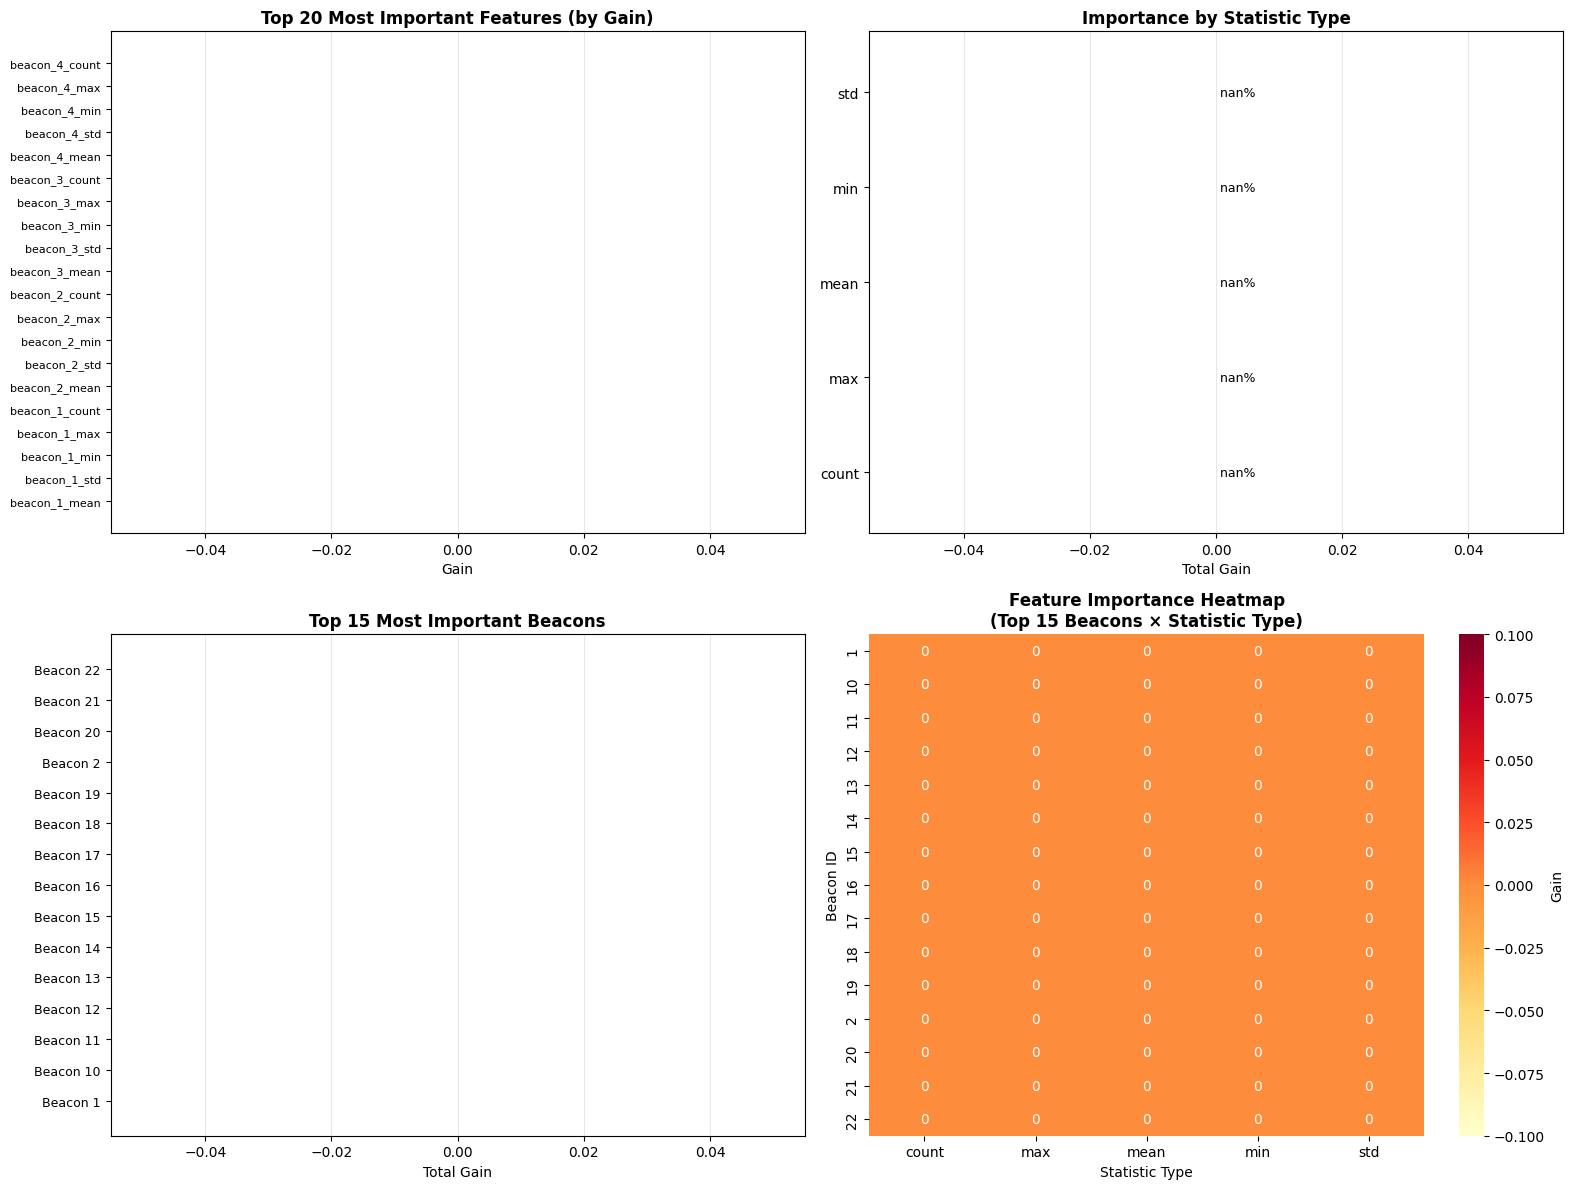


SUMMARY

Total features: 125
Features with non-zero importance: 0
Features with zero importance: 125

Top 125 features contribute 90% of total gain
That's 100.0% of all features

Most important statistic: nan (nan% of total gain)
Most important beacon: Beacon 1 (gain: 0.00)

KEY INSIGHTS

✅ Multiple statistic types contribute
   → Model uses diverse feature perspectives

✅ Top 5 beacons contribute nan% of gain
   → Information is distributed across many beacons

⚠️  125 features (100.0%) have zero importance
   → Model doesn't use many features
   → Could simplify model or add more informative features

✅ Saved detailed feature importance to: feature_importance.csv


In [47]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS FOR XGBOOST
# Add this code AFTER training your XGBoost model
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# ============================================================================
# 1. GET FEATURE IMPORTANCES FROM XGBOOST
# ============================================================================

# XGBoost provides multiple types of importance:
# - 'weight': number of times a feature appears in a tree
# - 'gain': average gain of splits using the feature
# - 'cover': average coverage of splits using the feature

# Get importance scores (using 'gain' as default - most informative)
importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
importance_weight = xgb_model.get_booster().get_score(importance_type='weight')
importance_cover = xgb_model.get_booster().get_score(importance_type='cover')

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'gain': [importance_gain.get(f'f{i}', 0) for i in range(len(feature_cols))],
    'weight': [importance_weight.get(f'f{i}', 0) for i in range(len(feature_cols))],
    'cover': [importance_cover.get(f'f{i}', 0) for i in range(len(feature_cols))]
})

# Sort by gain (most important metric)
feature_importance_df = feature_importance_df.sort_values('gain', ascending=False)

print("\n" + "-"*80)
print("TOP 20 MOST IMPORTANT FEATURES (by gain)")
print("-"*80)
print(feature_importance_df.head(20).to_string(index=False))

print("\n" + "-"*80)
print("BOTTOM 20 LEAST IMPORTANT FEATURES (by gain)")
print("-"*80)
print(feature_importance_df.tail(20).to_string(index=False))

# ============================================================================
# 2. ANALYZE BY STATISTIC TYPE (mean, std, min, max, count)
# ============================================================================

print("\n" + "="*80)
print("IMPORTANCE BY STATISTIC TYPE")
print("="*80)

# Extract statistic type from feature name
feature_importance_df['beacon_id'] = feature_importance_df['feature'].str.extract(r'beacon_(\d+)')[0]
feature_importance_df['stat_type'] = feature_importance_df['feature'].str.extract(r'_(mean|std|min|max|count)$')[0]

# Aggregate by statistic type
stat_importance = feature_importance_df.groupby('stat_type').agg({
    'gain': ['sum', 'mean', 'count'],
    'weight': ['sum', 'mean'],
    'cover': ['sum', 'mean']
}).round(2)

print("\nImportance by statistic type:")
print(stat_importance)

# Calculate percentage contribution
total_gain = feature_importance_df['gain'].sum()
stat_gain_pct = feature_importance_df.groupby('stat_type')['gain'].sum() / total_gain * 100
print("\n" + "-"*80)
print("Percentage contribution to total gain:")
print("-"*80)
for stat, pct in stat_gain_pct.sort_values(ascending=False).items():
    print(f"{stat:10s}: {pct:6.2f}%")

# ============================================================================
# 3. ANALYZE BY BEACON ID (which beacons are most important?)
# ============================================================================

print("\n" + "="*80)
print("IMPORTANCE BY BEACON ID")
print("="*80)

# Aggregate by beacon ID
beacon_importance = feature_importance_df.groupby('beacon_id').agg({
    'gain': 'sum',
    'weight': 'sum',
    'cover': 'sum'
}).sort_values('gain', ascending=False)

print("\nTop 10 most important beacons (by total gain):")
print(beacon_importance.head(10))

print("\nBottom 10 least important beacons (by total gain):")
print(beacon_importance.tail(10))

# ============================================================================
# 4. DETAILED ANALYSIS OF TOP FEATURES
# ============================================================================

print("\n" + "="*80)
print("DETAILED ANALYSIS OF TOP 10 FEATURES")
print("="*80)

top_10_features = feature_importance_df.head(10)

for idx, row in top_10_features.iterrows():
    feature_name = row['feature']
    beacon_id = row['beacon_id']
    stat_type = row['stat_type']
    gain = row['gain']
    weight = row['weight']
    
    print(f"\n{idx+1}. {feature_name}")
    print(f"   Beacon ID: {beacon_id}, Statistic: {stat_type}")
    print(f"   Gain: {gain:.2f}, Weight: {weight:.0f}")
    
    # Show distribution of this feature across different rooms
    feature_values = windowed_train_df[feature_name]
    print(f"   Value range: [{feature_values.min():.2f}, {feature_values.max():.2f}]")
    print(f"   Mean: {feature_values.mean():.2f}, Std: {feature_values.std():.2f}")
    
    # Show average value per room
    room_avg = windowed_train_df.groupby('room')[feature_name].mean().sort_values()
    print(f"   Average by room (top 3 highest):")
    for room, val in room_avg.tail(3).items():
        print(f"      Room {room}: {val:.2f}")

# ============================================================================
# 5. VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top 20 features by gain
ax1 = axes[0, 0]
top_20 = feature_importance_df.head(20).sort_values('gain')
ax1.barh(range(len(top_20)), top_20['gain'])
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['feature'], fontsize=8)
ax1.set_xlabel('Gain', fontsize=10)
ax1.set_title('Top 20 Most Important Features (by Gain)', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Importance by statistic type
ax2 = axes[0, 1]
stat_totals = feature_importance_df.groupby('stat_type')['gain'].sum().sort_values()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
ax2.barh(range(len(stat_totals)), stat_totals.values, color=colors[:len(stat_totals)])
ax2.set_yticks(range(len(stat_totals)))
ax2.set_yticklabels(stat_totals.index, fontsize=10)
ax2.set_xlabel('Total Gain', fontsize=10)
ax2.set_title('Importance by Statistic Type', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (stat, val) in enumerate(stat_totals.items()):
    pct = val / total_gain * 100
    ax2.text(val, i, f' {pct:.1f}%', va='center', fontsize=9)

# Plot 3: Top 15 beacons by total gain
ax3 = axes[1, 0]
top_beacons = beacon_importance.head(15).sort_values('gain')
ax3.barh(range(len(top_beacons)), top_beacons['gain'], color='#95E1D3')
ax3.set_yticks(range(len(top_beacons)))
ax3.set_yticklabels([f'Beacon {idx}' for idx in top_beacons.index], fontsize=9)
ax3.set_xlabel('Total Gain', fontsize=10)
ax3.set_title('Top 15 Most Important Beacons', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Heatmap of beacon importance by statistic type
ax4 = axes[1, 1]
pivot_table = feature_importance_df.pivot_table(
    values='gain',
    index='beacon_id',
    columns='stat_type',
    aggfunc='sum',
    fill_value=0
)
# Show only top 15 beacons
top_beacon_ids = beacon_importance.head(15).index
pivot_table_top = pivot_table.loc[top_beacon_ids]

sns.heatmap(pivot_table_top, annot=True, fmt='.0f', cmap='YlOrRd', 
            ax=ax4, cbar_kws={'label': 'Gain'})
ax4.set_title('Feature Importance Heatmap\n(Top 15 Beacons × Statistic Type)', 
              fontsize=12, fontweight='bold')
ax4.set_xlabel('Statistic Type', fontsize=10)
ax4.set_ylabel('Beacon ID', fontsize=10)

plt.tight_layout()
plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved visualization to: feature_importance_analysis.png")
plt.show()

# ============================================================================
# 6. FEATURE IMPORTANCE SUMMARY
# ============================================================================

print("\n" + "="*80)
print("SUMMARY")
print("="*80)

# Count features with zero importance
zero_importance = (feature_importance_df['gain'] == 0).sum()
print(f"\nTotal features: {len(feature_cols)}")
print(f"Features with non-zero importance: {len(feature_cols) - zero_importance}")
print(f"Features with zero importance: {zero_importance}")

# Top contributing features (90% of total gain)
cumsum_gain = feature_importance_df['gain'].cumsum()
total_gain = feature_importance_df['gain'].sum()
n_features_90pct = (cumsum_gain <= 0.9 * total_gain).sum()
print(f"\nTop {n_features_90pct} features contribute 90% of total gain")
print(f"That's {n_features_90pct / len(feature_cols) * 100:.1f}% of all features")

# Most important statistic type
most_important_stat = stat_gain_pct.idxmax()
most_important_stat_pct = stat_gain_pct.max()
print(f"\nMost important statistic: {most_important_stat} ({most_important_stat_pct:.1f}% of total gain)")

# Most important beacon
most_important_beacon = beacon_importance.idxmax()['gain']
most_important_beacon_gain = beacon_importance['gain'].max()
print(f"Most important beacon: Beacon {most_important_beacon} (gain: {most_important_beacon_gain:.2f})")

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Insight 1: Statistic distribution
if stat_gain_pct['mean'] > 40:
    print("\n✅ MEAN features dominate (>40% of gain)")
    print("   → Average signal values are most discriminative")
elif stat_gain_pct['std'] > 30:
    print("\n✅ STD features are important (>30% of gain)")
    print("   → Signal variability is key for classification")
elif stat_gain_pct['count'] > 30:
    print("\n✅ COUNT features are important (>30% of gain)")
    print("   → Detection frequency is highly discriminative")
    print("   → Different rooms have different detection patterns")
else:
    print("\n✅ Multiple statistic types contribute")
    print("   → Model uses diverse feature perspectives")

# Insight 2: Beacon concentration
top_5_beacon_pct = beacon_importance['gain'].head(5).sum() / total_gain * 100
if top_5_beacon_pct > 50:
    print(f"\n✅ Top 5 beacons contribute {top_5_beacon_pct:.1f}% of gain")
    print("   → A few beacons are highly discriminative")
    print(f"   → Most important beacons: {', '.join([f'Beacon {b}' for b in beacon_importance.head(5).index])}")
else:
    print(f"\n✅ Top 5 beacons contribute {top_5_beacon_pct:.1f}% of gain")
    print("   → Information is distributed across many beacons")

# Insight 3: Feature utilization
if zero_importance > len(feature_cols) * 0.3:
    print(f"\n⚠️  {zero_importance} features ({zero_importance/len(feature_cols)*100:.1f}%) have zero importance")
    print("   → Model doesn't use many features")
    print("   → Could simplify model or add more informative features")

print("\n" + "="*80)

# ============================================================================
# 7. SAVE FEATURE IMPORTANCE TO CSV
# ============================================================================

feature_importance_df.to_csv('feature_importance.csv', index=False)
print("✅ Saved detailed feature importance to: feature_importance.csv")